# Introduction to Quantitative Finance and Financial Risk
## Assignment 2: Efficient Frontier &amp; Portfolio Performance Evaluation

## Ioannis Michalopoulos
## p3352314

# Data Collection

This section downloads **weekly adjusted closing prices** for 10 selected stocks from Yahoo Finance using the `yfinance` library.  
The data spans from **January 1, 2014 to March 31, 2025**, and will be used to build and test optimal portfolios.  
Only the **'Close' prices** are retained, and rows with missing data are dropped to ensure a clean dataset for analysis.


In [2]:
#!pip install yfinance

In [3]:
import yfinance as yf
import pandas as pd

# Define the tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'JPM', 'V', 'JNJ']

# Define date range
start_date = '2014-01-01'
end_date = '2025-03-31'

# Download weekly data
data = yf.download(tickers, start=start_date, end=end_date, interval='1wk')

# Extract 'Close' prices from MultiIndex columns
close_prices = data.xs('Close', axis=1, level=0)

# Drop rows with any missing data 
close_prices.dropna(inplace=True)

# Preview the DataFrame
print(close_prices.head())



C:\Users\User\AppData\Local\Temp\ipykernel_15476\2816646283.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date, interval='1wk')
[*********************100%***********************]  10 of 10 completed

Ticker           AAPL       AMZN      GOOGL        JNJ        JPM       META  \
Date                                                                           
2014-01-01  16.785950  19.901501  28.330097  68.478462  42.601589  57.603985   
2014-01-08  16.983328  19.877001  28.592287  68.790749  42.453762  57.424961   
2014-01-15  17.066626  20.352501  28.948011  68.289627  42.769917  58.190758   
2014-01-22  15.743436  19.721500  27.935812  65.435432  40.983246  54.839146   
2014-01-29  15.814613  17.397499  28.312683  62.908085  40.402386  62.407627   

Ticker           MSFT      NVDA       TSLA          V  
Date                                                   
2014-01-01  30.315157  0.380507   9.957333  51.076828  
2014-01-08  29.790613  0.373434  10.751333  51.339676  
2014-01-15  30.115332  0.378385  11.778667  53.479511  
2014-01-22  30.198606  0.368012  11.892000  50.949993  
2014-01-29  30.265211  0.367305  11.915333  49.469646  


In [4]:
close_prices.head()

Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,META,MSFT,NVDA,TSLA,V
Date,,,,,,,,,,
2014-01-01,16.785950,19.901501,28.330097,68.478462,42.601589,57.603985,30.315157,0.380507,9.957333,51.076828
2014-01-08,16.983328,19.877001,28.592287,68.790749,42.453762,57.424961,29.790613,0.373434,10.751333,51.339676
2014-01-15,17.066626,20.352501,28.948011,68.289627,42.769917,58.190758,30.115332,0.378385,11.778667,53.479511
2014-01-22,15.743436,19.721500,27.935812,65.435432,40.983246,54.839146,30.198606,0.368012,11.892000,50.949993
2014-01-29,15.814613,17.397499,28.312683,62.908085,40.402386,62.407627,30.265211,0.367305,11.915333,49.469646


# Construct Weekly Returns

In this step, we compute the **weekly simple returns** for each of the 10 selected stocks.  
This is done by calculating the percentage change in closing prices from week to week.  



In [5]:
# Compute weekly simple returns
weekly_returns = close_prices.pct_change().dropna()

# Preview the returns DataFrame
print(weekly_returns.head())



Ticker          AAPL      AMZN     GOOGL       JNJ       JPM      META  \
Date                                                                     
2014-01-08  0.011759 -0.001231  0.009255  0.004560 -0.003470 -0.003108   
2014-01-15  0.004905  0.023922  0.012441 -0.007285  0.007447  0.013336   
2014-01-22 -0.077531 -0.031004 -0.034966 -0.041795 -0.041774 -0.057597   
2014-01-29  0.004521 -0.117841  0.013491 -0.038624 -0.014173  0.138012   
2014-02-05  0.053401  0.039776  0.045705  0.073309  0.045132  0.033466   

Ticker          MSFT      NVDA      TSLA         V  
Date                                                
2014-01-08 -0.017303 -0.018587  0.079740  0.005146  
2014-01-15  0.010900  0.013258  0.095554  0.041680  
2014-01-22  0.002765 -0.027415  0.009622 -0.047299  
2014-01-29  0.002206 -0.001922  0.001962 -0.029055  
2014-02-05  0.022558  0.043004  0.100095  0.036310  


# Efficient Frontier (No Short-Selling)

In this step, we construct the **Mean-Variance Efficient Frontier** under the constraints of:
- **No short-selling** (portfolio weights must be ≥ 0)
- **Full investment** (portfolio weights must sum to 1)

We calculate portfolios across a range of target returns and minimize the portfolio variance for each, subject to the constraints.  
We then identify and mark on the plot:
- The **Minimum Risk Portfolio** (lowest standard deviation)
- The **Mean-Variance Efficient (MVE) Portfolio** with the **highest Sharpe ratio**, assuming a risk-free rate of 0%.

The result is a visual representation of the tradeoff between risk and return for optimal portfolios under the no short-selling condition.


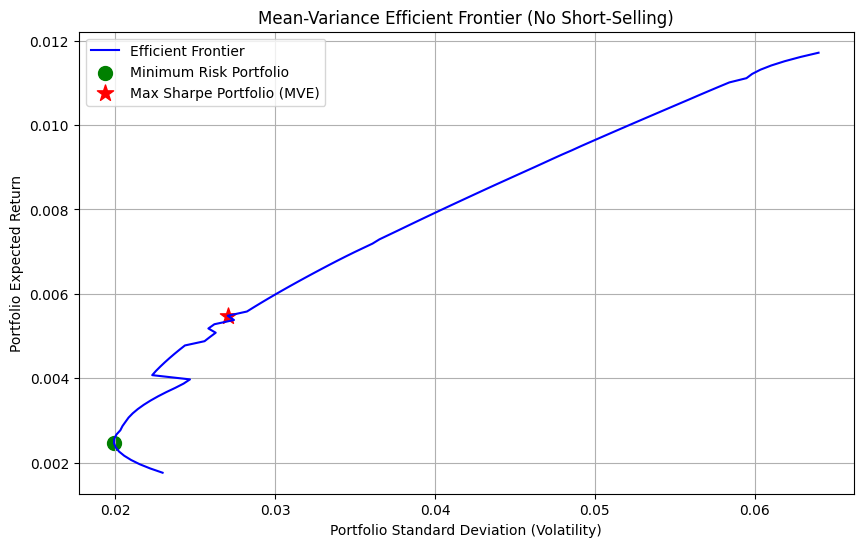

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Set seed for reproducibility
np.random.seed(42)

# Expected returns (mean of weekly returns)
mu = weekly_returns.mean().values

# Covariance matrix of weekly returns
cov = weekly_returns.cov().values

# Number of assets
n_assets = len(mu)

# Define the objective: minimize portfolio variance
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

# Constraints: weights sum to 1, and weights >= 0 (no short-selling)
constraints = ({
    'type': 'eq',
    'fun': lambda w: np.sum(w) - 1
})
bounds = [(0, 1)] * n_assets

# Generate Efficient Frontier
target_returns = np.linspace(mu.min(), mu.max(), 100)
frontier_vols = []
frontier_weights = []

for target in target_returns:
    additional_constraint = {
        'type': 'eq',
        'fun': lambda w, target=target: w @ mu - target
    }
    
    result = minimize(
        portfolio_variance,
        x0=np.ones(n_assets) / n_assets,
        args=(cov,),
        method='SLSQP',
        bounds=bounds,
        constraints=[constraints, additional_constraint]
    )
    
    if result.success:
        frontier_vols.append(np.sqrt(result.fun))
        frontier_weights.append(result.x)
    else:
        frontier_vols.append(np.nan)
        frontier_weights.append(np.full(n_assets, np.nan))

# Convert results to arrays
frontier_vols = np.array(frontier_vols)
frontier_returns = target_returns
frontier_weights = np.array(frontier_weights)

# Find the Minimum Risk Portfolio
min_vol_index = np.nanargmin(frontier_vols)
min_vol_weights = frontier_weights[min_vol_index]
min_vol_return = frontier_returns[min_vol_index]
min_vol_std = frontier_vols[min_vol_index]

# Find the Maximum Sharpe Ratio Portfolio (risk-free rate = 0%)
sharpe_ratios = frontier_returns / frontier_vols
max_sharpe_index = np.nanargmax(sharpe_ratios)
max_sharpe_weights = frontier_weights[max_sharpe_index]
max_sharpe_return = frontier_returns[max_sharpe_index]
max_sharpe_std = frontier_vols[max_sharpe_index]

# Plot Efficient Frontier
plt.figure(figsize=(10, 6))
plt.plot(frontier_vols, frontier_returns, label='Efficient Frontier', color='blue')
plt.scatter(min_vol_std, min_vol_return, color='green', marker='o', s=100, label='Minimum Risk Portfolio')
plt.scatter(max_sharpe_std, max_sharpe_return, color='red', marker='*', s=150, label='Max Sharpe Portfolio (MVE)')
plt.xlabel('Portfolio Standard Deviation (Volatility)')
plt.ylabel('Portfolio Expected Return')
plt.title('Mean-Variance Efficient Frontier (No Short-Selling)')
plt.legend()
plt.grid(True)
plt.show()


# Efficient Frontier (With Short-Selling)

In this step, we **recompute the Mean-Variance Efficient Frontier**, this time **allowing short-selling**.  
Short positions are permitted up to -100% per asset, meaning portfolio weights can range from -1 to +1.

We:
- Use the same range of target returns as before.
- Minimize portfolio variance under full investment (weights sum to 1) with short-selling bounds.
- Identify the **Minimum Risk Portfolio** and the **Maximum Sharpe Ratio Portfolio** under short-selling.

Finally, we **overlay both frontiers** (with and without short-selling) on the same plot to visually compare how allowing short positions changes the set of optimal portfolios.


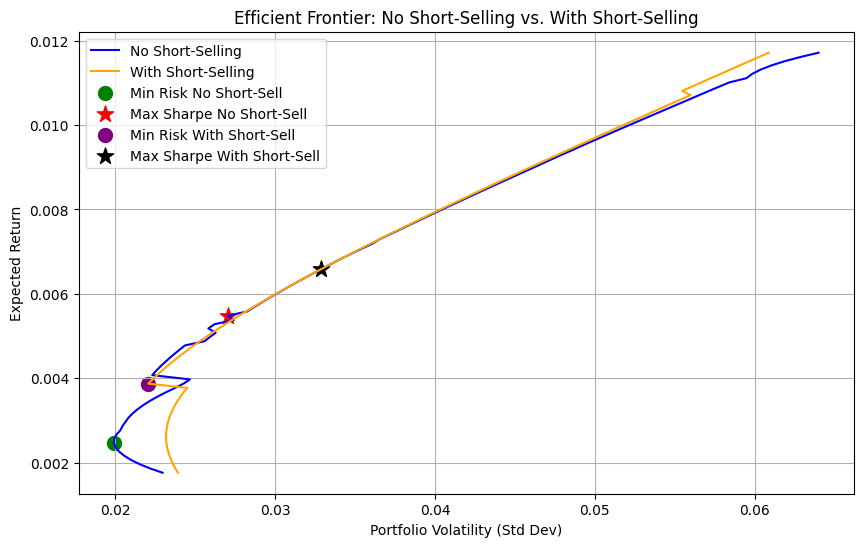

In [7]:
# Bounds allowing short-selling up to -100% and +100%
bounds_short = [(-1, 1)] * n_assets

# Recompute Efficient Frontier with short-selling
frontier_vols_short = []
frontier_weights_short = []

for target in target_returns:
    additional_constraint = {
        'type': 'eq',
        'fun': lambda w, target=target: w @ mu - target
    }
    
    result = minimize(
        portfolio_variance,
        x0=np.ones(n_assets) / n_assets,
        args=(cov,),
        method='SLSQP',
        bounds=bounds_short,
        constraints=[constraints, additional_constraint]
    )
    
    if result.success:
        frontier_vols_short.append(np.sqrt(result.fun))
        frontier_weights_short.append(result.x)
    else:
        frontier_vols_short.append(np.nan)
        frontier_weights_short.append(np.full(n_assets, np.nan))

frontier_vols_short = np.array(frontier_vols_short)
frontier_weights_short = np.array(frontier_weights_short)

# Find Minimum Risk Portfolio with short-selling
min_vol_index_short = np.nanargmin(frontier_vols_short)
min_vol_return_short = target_returns[min_vol_index_short]
min_vol_std_short = frontier_vols_short[min_vol_index_short]

# Find Max Sharpe Portfolio with short-selling
sharpe_ratios_short = target_returns / frontier_vols_short
max_sharpe_index_short = np.nanargmax(sharpe_ratios_short)
max_sharpe_return_short = target_returns[max_sharpe_index_short]
max_sharpe_std_short = frontier_vols_short[max_sharpe_index_short]

# Plot both Efficient Frontiers
plt.figure(figsize=(10, 6))
plt.plot(frontier_vols, frontier_returns, label='No Short-Selling', color='blue')
plt.plot(frontier_vols_short, target_returns, label='With Short-Selling', color='orange')
plt.scatter(min_vol_std, min_vol_return, color='green', marker='o', s=100, label='Min Risk No Short-Sell')
plt.scatter(max_sharpe_std, max_sharpe_return, color='red', marker='*', s=150, label='Max Sharpe No Short-Sell')
plt.scatter(min_vol_std_short, min_vol_return_short, color='purple', marker='o', s=100, label='Min Risk With Short-Sell')
plt.scatter(max_sharpe_std_short, max_sharpe_return_short, color='black', marker='*', s=150, label='Max Sharpe With Short-Sell')
plt.xlabel('Portfolio Volatility (Std Dev)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier: No Short-Selling vs. With Short-Selling')
plt.legend()
plt.grid(True)
plt.show()


##  Impact of Short-Selling on the Efficient Frontier

This plot compares the Mean-Variance Efficient Frontier under two scenarios: **no short-selling** (blue curve) and **with short-selling allowed** (orange curve). The key differences observed are:

1. **Shape and Range of the Frontier:**
   - The frontier with short-selling is slightly broader and extends both lower in risk and higher in return compared to the no short-selling case.
   - This reflects increased flexibility in portfolio construction when negative weights (short positions) are allowed.

2. **Minimum Risk Portfolio:**
   - The minimum risk portfolio with short-selling (purple dot) achieves a marginally lower volatility than its counterpart without short-selling (green dot).
   - This indicates enhanced risk-reduction capabilities through shorting, which helps offset correlated exposures among assets.

3. **Maximum Sharpe Ratio Portfolio (MVE Portfolio):**
   - The max Sharpe ratio portfolio under short-selling (black star) delivers a higher return for a slightly higher risk than the version without short-selling (red star).
   - This results in a **higher Sharpe ratio**, indicating superior risk-adjusted performance.

4. **Crossover Region:**
   - The frontiers largely overlap in the moderate risk-return range, but diverge more significantly at the low-risk and high-return ends.
   - This highlights how the benefits of short-selling become more prominent when targeting portfolio extremes.

5. **Conclusion:**
   - Allowing short-selling expands the efficient frontier, offering greater potential for both diversification and higher returns.
   - However, it also introduces practical limitations such as borrowing costs and leverage risk that are not accounted for in this theoretical framework.



## Out-of-Sample Evaluation: Jan–Mar 2025

In this step, we evaluate the **out-of-sample performance** of the portfolios constructed as of 31 December 2024. Specifically, we:

- Use the previously computed weights for the **Minimum Risk Portfolio** and **Maximum Sharpe Ratio Portfolio** (without short-selling).
- Compare these portfolios to a **naive equal-weighted portfolio**.
- Analyze their performance over the period **1 January 2025 to 31 March 2025**.

For each portfolio, we compute:
- **Cumulative returns** to visualize performance growth over time.
- **Annualized volatility** to assess out-of-sample risk.

This analysis helps us assess the predictive power and real-world robustness of our mean-variance optimized portfolios.


Out-of-sample annualized volatility:
 - Min Risk Portfolio: 0.1183
 - Max Sharpe Portfolio: 0.2096
 - Equal-weighted Portfolio: 0.2640


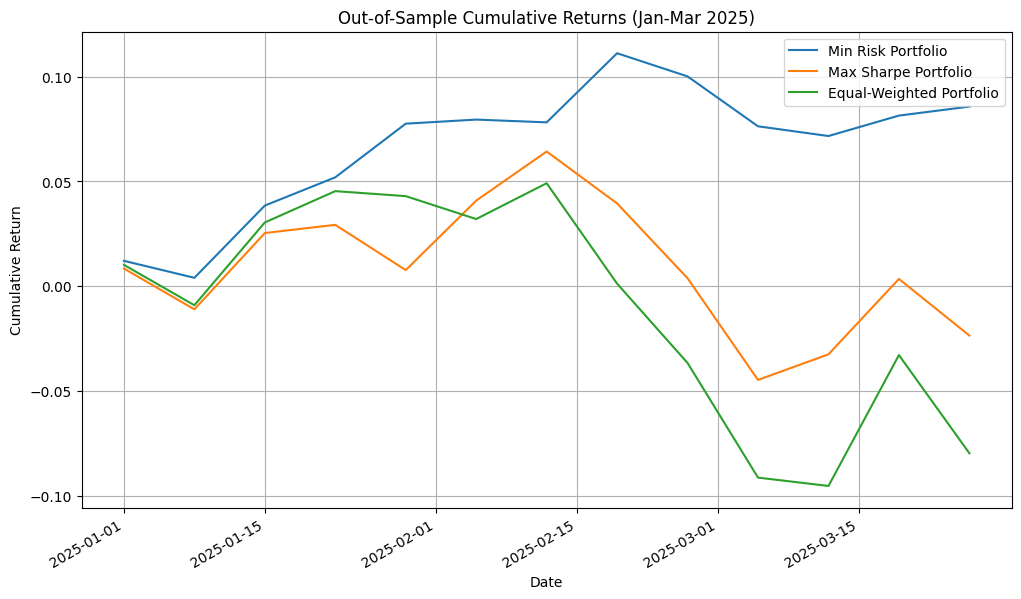

In [8]:
# 1. Define the in-sample period end and out-of-sample period
in_sample_end = '2024-12-31'
out_sample_start = '2025-01-01'
out_sample_end = '2025-03-31'

# 2. Split the weekly returns into in-sample and out-of-sample 
weekly_returns.index = pd.to_datetime(weekly_returns.index)  # Ensure datetime index

in_sample_returns = weekly_returns[weekly_returns.index <= in_sample_end]
out_sample_returns = weekly_returns[(weekly_returns.index >= out_sample_start) & (weekly_returns.index <= out_sample_end)]

# 3. Retrieve weights from the no short-selling frontier as of 31 Dec 2024 

# Minimum Risk Portfolio weights (no short-selling)
w_min_risk = min_vol_weights

# Max Sharpe Portfolio weights (no short-selling)
w_max_sharpe = max_sharpe_weights

# Equal-weighted portfolio weights
w_equal = np.ones(n_assets) / n_assets

# 4. Calculate weekly portfolio returns out-of-sample

def portfolio_returns(weights, returns_df):
    return returns_df @ weights

port_ret_min_risk = portfolio_returns(w_min_risk, out_sample_returns)
port_ret_max_sharpe = portfolio_returns(w_max_sharpe, out_sample_returns)
port_ret_equal = portfolio_returns(w_equal, out_sample_returns)

# 5. Calculate cumulative returns
cum_ret_min_risk = (1 + port_ret_min_risk).cumprod() - 1
cum_ret_max_sharpe = (1 + port_ret_max_sharpe).cumprod() - 1
cum_ret_equal = (1 + port_ret_equal).cumprod() - 1

# 6. Calculate volatility (std dev) of out-of-sample returns
vol_min_risk = port_ret_min_risk.std() * np.sqrt(52)  # annualized volatility assuming 52 weeks/year
vol_max_sharpe = port_ret_max_sharpe.std() * np.sqrt(52)
vol_equal = port_ret_equal.std() * np.sqrt(52)

print(f'Out-of-sample annualized volatility:')
print(f' - Min Risk Portfolio: {vol_min_risk:.4f}')
print(f' - Max Sharpe Portfolio: {vol_max_sharpe:.4f}')
print(f' - Equal-weighted Portfolio: {vol_equal:.4f}')

# 7. Plot cumulative returns

import matplotlib.dates as mdates

plt.figure(figsize=(12, 7))
plt.plot(cum_ret_min_risk.index, cum_ret_min_risk, label='Min Risk Portfolio')
plt.plot(cum_ret_max_sharpe.index, cum_ret_max_sharpe, label='Max Sharpe Portfolio')
plt.plot(cum_ret_equal.index, cum_ret_equal, label='Equal-Weighted Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Out-of-Sample Cumulative Returns (Jan-Mar 2025)')
plt.legend()
plt.grid(True)

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.show()


## Out-of-Sample Performance Evaluation (Jan–Mar 2025)

The plot above shows the cumulative returns of three portfolios evaluated on out-of-sample data from **1 January to 31 March 2025**:

- **Minimum Risk Portfolio** (blue): This portfolio demonstrated the most stable and superior performance. It consistently grew and ended the quarter with the highest cumulative return and lowest drawdowns. It also had the **lowest out-of-sample annualized volatility of 0.1183**, confirming its defensive and stable nature.

- **Maximum Sharpe Ratio Portfolio** (orange): Initially performed well and outpaced the equal-weighted portfolio until mid-February. However, it experienced a noticeable decline thereafter. It had a **moderate annualized volatility of 0.2096**, indicating higher risk-taking, which didn’t fully translate into superior returns over the period.

- **Equal-Weighted Portfolio** (green): Underperformed both optimized portfolios, especially in the second half of the quarter. It suffered the largest drawdown and ended with negative cumulative returns. It also had the **highest annualized volatility at 0.2640**, reflecting lack of risk control and diversification efficiency.

## Summary:
- **The Minimum Risk Portfolio showed the most stable and predictive performance**, with the best return-to-risk balance out-of-sample.
- The **Max Sharpe Portfolio offered some upside**, but came with greater volatility and less consistency.
- The **Equal-Weighted Portfolio was the most volatile and least effective**, underscoring the advantages of optimization in portfolio design.
